In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',20)
pd.set_option('display.max_rows',100)
plt.style.use('ggplot')

from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap

In [2]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [3]:
df = pd.read_excel('Mod_Clothing Cleaned.xlsx')
df.head()

,item_id,size,quality,cup_size,hips,bra_size,category,Height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text
0,123373,7,5,d,38,34,new,5.50,Emily,just right,small,991571,8.5,NaN,NaN,NaN
1,123373,13,3,b,30,36,new,5.17,sydneybraden2001,just right,small,587883,9.5,NaN,NaN,NaN
2,123373,7,2,b,39,32,new,5.58,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,21,5,dd/e,39,36,new,5.42,alexmeyer626,just right,fit,875643,10.0,NaN,NaN,NaN
4,123373,18,5,b,39,36,new,5.17,dberrones1,slightly long,small,944840,8.5,NaN,NaN,NaN


### 5. Find the outliers which are below and above 2.5 * IQR -Q1 and 2.5 * IQR + Q3

#### Since specifically mentioned 2.5 instead of standard 1.5 to identify outliers, we will use 2.5 only.

In [4]:
# Extracting the Numerical Columns
num_col = []
for i in df.columns:
    if df[i].dtype == 'object':
        continue
    num_col.append(i)
num_col.remove('user_id')
num_col.remove('item_id')
#print(num_col)

In [5]:
# Function to calculate lower and upper whiskers of a column
def detect_outlier(col):
    Q1,Q3 = np.percentile(col,[25,75])
    IQR = Q3 - Q1
    lr,ur = Q1-2.5*IQR,2.5*IQR+Q3
    return lr,ur

In [6]:
for i in num_col:
    if len(df[df[i] <= detect_outlier(df[i])[0]]) > 0:
        print(f"'{i}' column has records lower than it's lower whisker")

'hips' column has records lower than it's lower whisker
'Height' column has records lower than it's lower whisker


In [7]:
detect_outlier(df['hips'])

(30.5, 48.5)

In [8]:
df[df['hips'] <= detect_outlier(df['hips'])[0]].head(3)

,item_id,size,quality,cup_size,hips,bra_size,category,Height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text
1,123373,13,3,b,30,36,new,5.17,sydneybraden2001,just right,small,587883,9.5,NaN,NaN,NaN
45,123373,7,5,dd/e,30,34,new,5.08,riehl.lilith,just right,fit,931858,8.0,NaN,NaN,NaN
226,124124,8,5,c,30,38,new,5.00,cmred.88,just right,fit,20806,9.0,NaN,NaN,NaN


In [9]:
for i in num_col:
    if len(df[df[i] >= detect_outlier(df[i])[1]]) > 0:
        print(f"'{i}' column has records higher than it's upper whisker")

'size' column has records higher than it's upper whisker
'hips' column has records higher than it's upper whisker
'bra_size' column has records higher than it's upper whisker
'Height' column has records higher than it's upper whisker


In [10]:
detect_outlier(df['size'])

(-9.5, 32.5)

In [11]:
df[df['size'] >= detect_outlier(df['size'])[1]].head(3)

,item_id,size,quality,cup_size,hips,bra_size,category,Height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text
11,123373,33,5,ddd/f,60,44,new,5.33,tera.oh,just right,small,422613,9.0,NaN,NaN,NaN
107,124124,38,4,d,39,36,new,5.42,candlecrazy80,slightly short,small,737821,7.5,NaN,NaN,NaN
129,124124,38,3,dd/e,54,42,new,5.75,natalie.lestrange,just right,large,293138,8.0,NaN,NaN,NaN


#### There are values for above mentioned columns which are not in the specified range of lower and upper whiskers. They are outliers but not random mistakes. The data in the columns just spans over huge ranges. We can't remove them. 

---

### 6. Check for the category dress reviews and visualize the top 10 reviews using any relevant plot. Identify the negative reviews if there are any.

#### Creating 'Sentiment' column for Reviews. Using VADER approach

In [12]:
# Creating 'index' column
df.reset_index(inplace=True)

In [13]:
df.head()

,index,item_id,size,quality,cup_size,hips,bra_size,category,Height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text
0,0,123373,7,5,d,38,34,new,5.50,Emily,just right,small,991571,8.5,NaN,NaN,NaN
1,1,123373,13,3,b,30,36,new,5.17,sydneybraden2001,just right,small,587883,9.5,NaN,NaN,NaN
2,2,123373,7,2,b,39,32,new,5.58,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,3,123373,21,5,dd/e,39,36,new,5.42,alexmeyer626,just right,fit,875643,10.0,NaN,NaN,NaN
4,4,123373,18,5,b,39,36,new,5.17,dberrones1,slightly long,small,944840,8.5,NaN,NaN,NaN


In [14]:
sia = SentimentIntensityAnalyzer()

In [15]:
# Running the polarity score on entire dataset
res = {}
for i,row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['review_text'])
    myid = row['index']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/82412 [00:00<?, ?it/s]

In [16]:
#res

In [17]:
vaders = pd.DataFrame(res).T
vaders

,neg,neu,pos,compound
0,0.0,1.000,0.000,0.0000
1,0.0,1.000,0.000,0.0000
2,0.0,1.000,0.000,0.0000
3,0.0,1.000,0.000,0.0000
4,0.0,1.000,0.000,0.0000
...,...,...,...,...
82407,0.0,0.233,0.767,0.5093
82408,0.0,0.588,0.412,0.9273
82409,0.0,0.645,0.355,0.9001
82410,0.0,0.558,0.442,0.9017


In [18]:
df = pd.concat([df,vaders['compound']], axis=1).copy()
df.tail()

,index,item_id,size,quality,cup_size,hips,bra_size,category,Height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text,compound
82407,82407,807722,8,4,b,39,36,outerwear,5.67,Jennifer,just right,fit,727820,8.5,average,Cute jacket!,Cute jacket!,0.5093
82408,82408,807722,12,5,ddd/f,39,34,outerwear,5.42,Kelli,slightly long,small,197040,9.0,NaN,It's a beautiful jacket.,It's a beautiful jacket. I love how it's knit ...,0.9273
82409,82409,807722,12,5,dddd/g,36,32,outerwear,5.33,elacount,just right,fit,102493,9.0,NaN,I love this blazer. It is,I love this blazer. It is a great office piece...,0.9001
82410,82410,807722,12,4,c,39,36,outerwear,5.25,jennaklinner,just right,fit,756491,10.0,NaN,I love this blazer!! I wo,I love this blazer!! I wore it yesterday and g...,0.9017
82411,82411,807722,4,4,d,39,32,outerwear,6.00,maireadsteadman,just right,fit,78305,9.0,NaN,I love this piece. I'm re,I love this piece. I'm really happy with it!,0.8585


In [19]:
df.drop('index', axis=1, inplace=True)
df.rename(columns={'compound':'Sentiment'}, inplace=True)

In [20]:
df.tail()

,item_id,size,quality,cup_size,hips,bra_size,category,Height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text,Sentiment
82407,807722,8,4,b,39,36,outerwear,5.67,Jennifer,just right,fit,727820,8.5,average,Cute jacket!,Cute jacket!,0.5093
82408,807722,12,5,ddd/f,39,34,outerwear,5.42,Kelli,slightly long,small,197040,9.0,NaN,It's a beautiful jacket.,It's a beautiful jacket. I love how it's knit ...,0.9273
82409,807722,12,5,dddd/g,36,32,outerwear,5.33,elacount,just right,fit,102493,9.0,NaN,I love this blazer. It is,I love this blazer. It is a great office piece...,0.9001
82410,807722,12,4,c,39,36,outerwear,5.25,jennaklinner,just right,fit,756491,10.0,NaN,I love this blazer!! I wo,I love this blazer!! I wore it yesterday and g...,0.9017
82411,807722,4,4,d,39,32,outerwear,6.00,maireadsteadman,just right,fit,78305,9.0,NaN,I love this piece. I'm re,I love this piece. I'm really happy with it!,0.8585


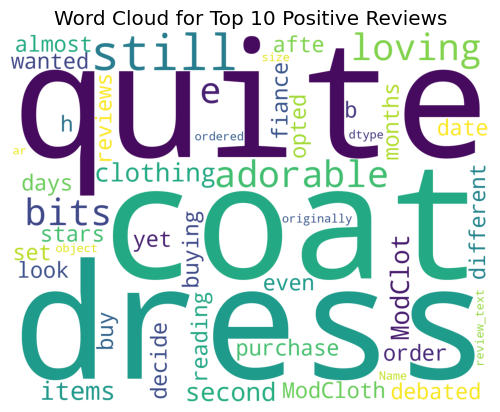

In [21]:
# Visualizing Top 10 positive reviews
wc = WordCloud(width=1300, height=1000, background_color='white', random_state=42).generate(str(df.nlargest(10, 'Sentiment')['review_text']))
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud for Top 10 Positive Reviews')
plt.show()

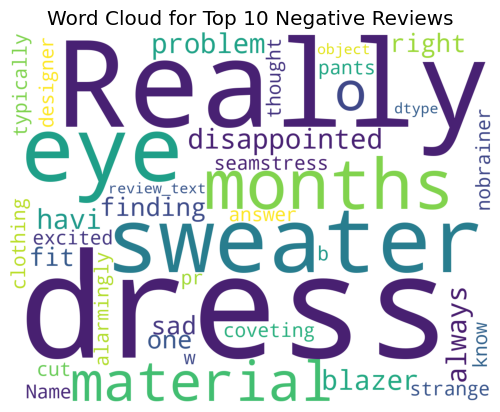

In [22]:
# Visualizing Top 10 negative reviews
wc = WordCloud(width=1300, height=1000, background_color='white', random_state=42).generate(str(df.nsmallest(10, 'Sentiment')['review_text']))
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud for Top 10 Negative Reviews')
plt.show()

---

### 7. Find out the average shoe size for the different fits of the customer. Visualize using any relevant plot. Explain that, Is there any significant different shoe sizes for different fits ?

In [23]:
df.groupby('fit')['shoe_size'].mean()

fit
fit      8.195417
large    8.235303
small    8.283389
Name: shoe_size, dtype: float64

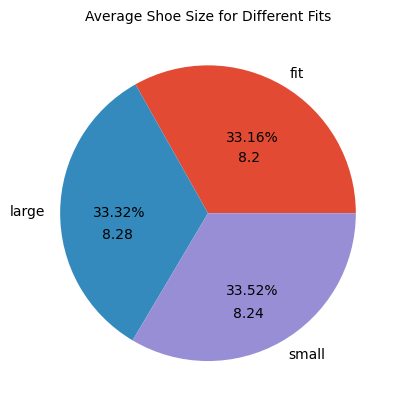

In [24]:
plt.pie(df.groupby('fit')['shoe_size'].mean(), labels=['fit','large','small'], autopct='%.2f%%')
plt.title('Average Shoe Size for Different Fits', fontsize=10)
plt.text(0.2,0.35,str(round(df.groupby('fit')['shoe_size'].mean()[0],2)))
plt.text(0.17,-0.7,str(round(df.groupby('fit')['shoe_size'].mean()[1],2)))
plt.text(-0.72,-0.17,str(round(df.groupby('fit')['shoe_size'].mean()[2],2)))
plt.show()

#### There is no significant difference among shoe sizes for different fit types. Very close to each other. Average show size is 8.24

---

### 8. Identify the customer’s common shoe width and average size for those who purchased the maximum quality. Is the mode of shoe width affect the user review? Visualize using the appropriate plot.

In [25]:
df_max_quality = df[df['quality'] == 5]

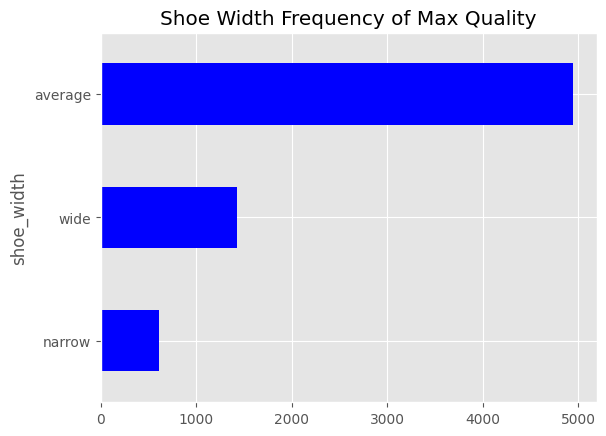

In [26]:
df_max_quality['shoe_width'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Shoe Width Frequency of Max Quality', colormap='winter')
plt.show()

#### As seen, common shoe width of customers who purchased maximum quality is 'average'.

In [27]:
df_max_quality['shoe_size'].mean()

8.196939364120661

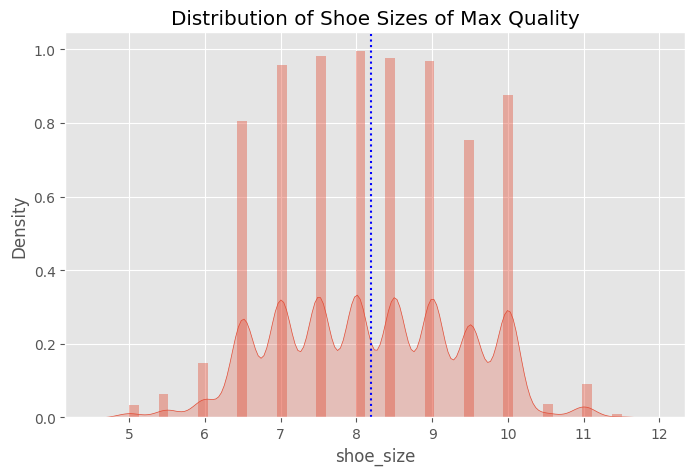

In [28]:
plt.figure(figsize=(8,5))
sns.distplot(df_max_quality['shoe_size'], kde_kws={'fill':True})
plt.title("Distribution of Shoe Sizes of Max Quality")
plt.axvline(df_max_quality['shoe_size'].mean(), color='b', linestyle='dotted')
plt.show()

#### Average shoe size is roughly 8.2

In [29]:
# Removing the rows with missing values in 'shoe_width' and 'review_text' columns.
df1 = df_max_quality.dropna(subset=['shoe_width','review_text'])

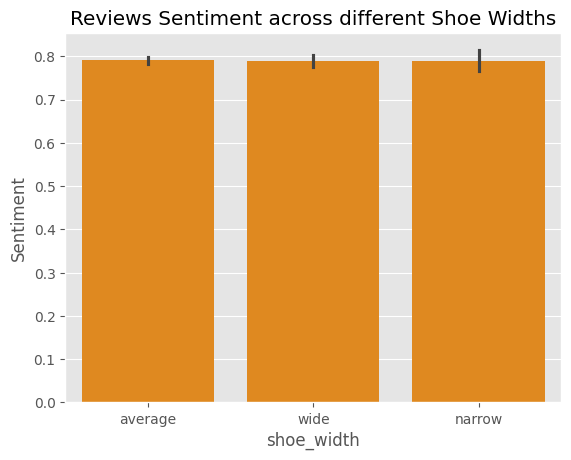

In [30]:
sns.barplot(data=df1, x='shoe_width', y='Sentiment', color='darkorange')
plt.title('Reviews Sentiment across different Shoe Widths')
plt.show()

#### All the widths have good positive sentiment.

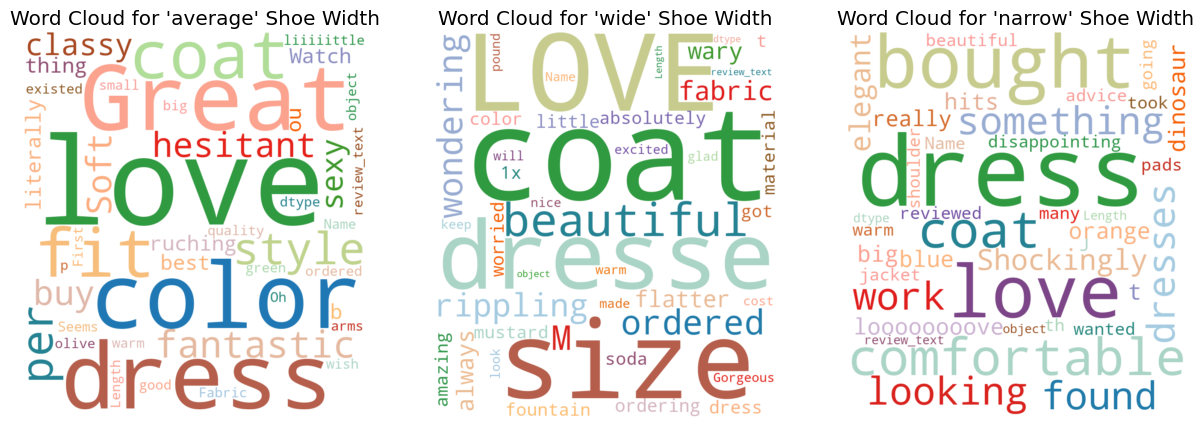

In [31]:
colors = ["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6"]
cmap = LinearSegmentedColormap.from_list("my_colormap", colors)

fig, ax = plt.subplots(1, 3, figsize=(15, 12))
for i, j in enumerate(df1['shoe_width'].unique()):
    wc = WordCloud(width=800, height=900, background_color='white', colormap=cmap, random_state=1).generate(str(df1[df1['shoe_width'] == j]['review_text']))
    ax[i].set_title(f"Word Cloud for '{j}' Shoe Width")
    ax[i].imshow(wc, interpolation='bilinear')
    ax[i].axis("off")
plt.show()

#### Again, we can see positive words across all the widths. There are some negative words in 'narrow' shoe width like 'dissapointing' and 'shockingly' but they are in small numbers. We can say that mode of shoe width doesn't much affect user reviews.

---

### 9. Extract the records belonging to the top 10 reviews, and then find the review summary for the different cup sizes. The basic analysis explains what you would try to infer. Try to use visualization.

In [32]:
df.sort_values('Sentiment', ascending=False).head(10)

,item_id,size,quality,cup_size,hips,bra_size,category,Height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text,Sentiment
13668,169727,8,4,c,36,34,dresses,5.67,amysolowiej,just right,fit,971354,9.5,NaN,I'm still loving this ado,I'm still loving this adorable dress to bits e...,0.9982
25805,394692,26,5,dd/e,39,36,sale,5.50,Stephanie,just right,fit,894276,10.0,NaN,I have quite a few clothi,I have quite a few clothing items from ModClot...,0.9981
15958,175771,1,5,b,36,32,dresses,5.17,Yaritza,just right,fit,718929,6.5,NaN,This is my second purchas,This is my second purchase from ModCloth. My ...,0.9980
77540,777527,20,5,c,34,40,new,5.58,Amber,just right,fit,97382,9.0,wide,Couldn't decide between 4,Couldn't decide between 4 different coats on h...,0.9979
11980,165716,15,5,d,39,36,dresses,5.17,kellyh1109,just right,large,375789,6.5,NaN,Not quite 5 stars ? but a,Not quite 5 stars ? but almost I had been look...,0.9978
81295,806479,12,3,c,39,36,outerwear,5.08,dpawtisch,just right,fit,427381,9.0,NaN,I debated buying this coa,I debated buying this coat for 3 days and afte...,0.9978
20027,298256,20,5,c,39,38,dresses,5.75,Stephanie,just right,fit,41608,6.5,NaN,I have wanted to buy this,"I have wanted to buy this dress for months, an...",0.9976
26027,396846,12,5,b,41,38,dresses,5.58,Kristen,slightly long,fit,490414,9.5,NaN,My fiance and I haven't e,"My fiance and I haven't even set a date yet, b...",0.9975
27857,399074,8,4,dddd/g,42,32,sale,5.50,Lori,slightly short,fit,891208,10.0,NaN,After reading through rev,After reading through reviews I opted to order...,0.9975
69430,722362,8,4,c,36,36,bottoms,5.42,Rowan,slightly long,fit,374812,8.5,average,I originally ordered thes,I originally ordered these in a size 5 they ar...,0.9974


In [33]:
top_reviews = df.sort_values('Sentiment', ascending=False).head(10)

cup_size_summary = top_reviews.groupby('cup_size')['review_summary'].value_counts()
cup_size_summary.to_frame().drop('count',axis=1)

Empty DataFrame
Columns: []
Index: [(b, My fiance and I haven't e), (b, This is my second purchas), (c, Couldn't decide between 4), (c, I debated buying this coa), (c, I have wanted to buy this), (c, I originally ordered thes), (c, I'm still loving this ado), (d, Not quite 5 stars ? but a), (dd/e, I have quite a few clothi), (dddd/g, After reading through rev)]

#### We can't do much with this, just view this in tabular form like above. We were not able to come up with any visualization to view this. We can conclude that cup_size 'c' has most number of positive reviews in top 10 followed by 'b'.

---

### 10. Identify the most common review that we got from the customer whose hips size is greater than 35. Find out what kind of inference you can make.

In [34]:
df2 = df[df['hips'] > 35].dropna(subset=['review_text'])
df2.head()

,item_id,size,quality,cup_size,hips,bra_size,category,Height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text,Sentiment
6709,152702,4,4,b,37,32,new,5.50,avNYC,just right,small,668176,9.0,average,Too much ruching,"I liked the color, the silhouette, and the fab...",-0.7262
6710,152702,4,5,c,36,34,new,5.50,lanwei91,slightly short,fit,320759,7.5,NaN,Suits my body type!,From the other reviews it seems like this dres...,0.8802
6711,152702,4,3,a,39,34,new,5.25,angeladevoe5678,just right,fit,144785,9.0,NaN,I love the design and fit,I love the design and fit of this dress! I wo...,-0.2771
6714,152702,8,4,d,40,34,new,5.08,no_poncho,very short,small,944346,6.5,NaN,I'm simply too tall for t,I'm simply too tall for this. The wrap portion...,-0.4215
6715,152702,4,4,a,39,34,new,5.25,lennaroe,slightly long,small,986184,7.5,NaN,I snagged this dress when,I snagged this dress when it went on sale and ...,0.8940


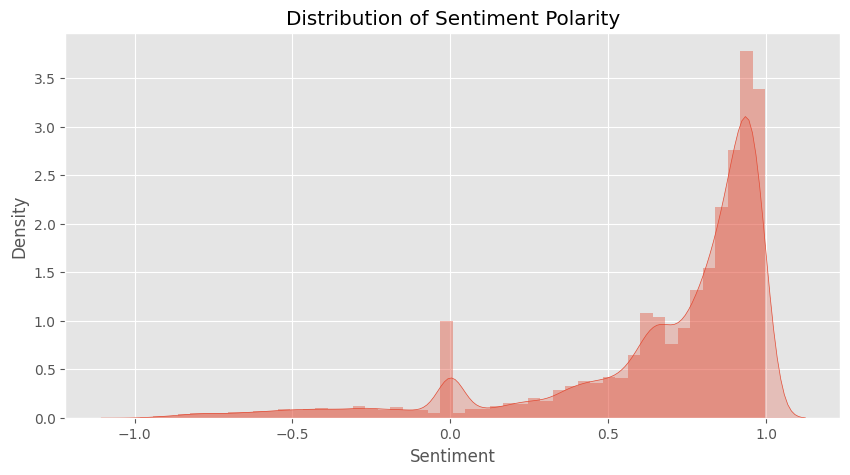

In [35]:
plt.figure(figsize=(10,5))
sns.distplot(df2['Sentiment'], kde=True, kde_kws={'fill':True})
plt.title('Distribution of Sentiment Polarity')
plt.show()

#### We can observe that most of them have a bright outlook towards their dresses. Let's look into reviews which are frequent.

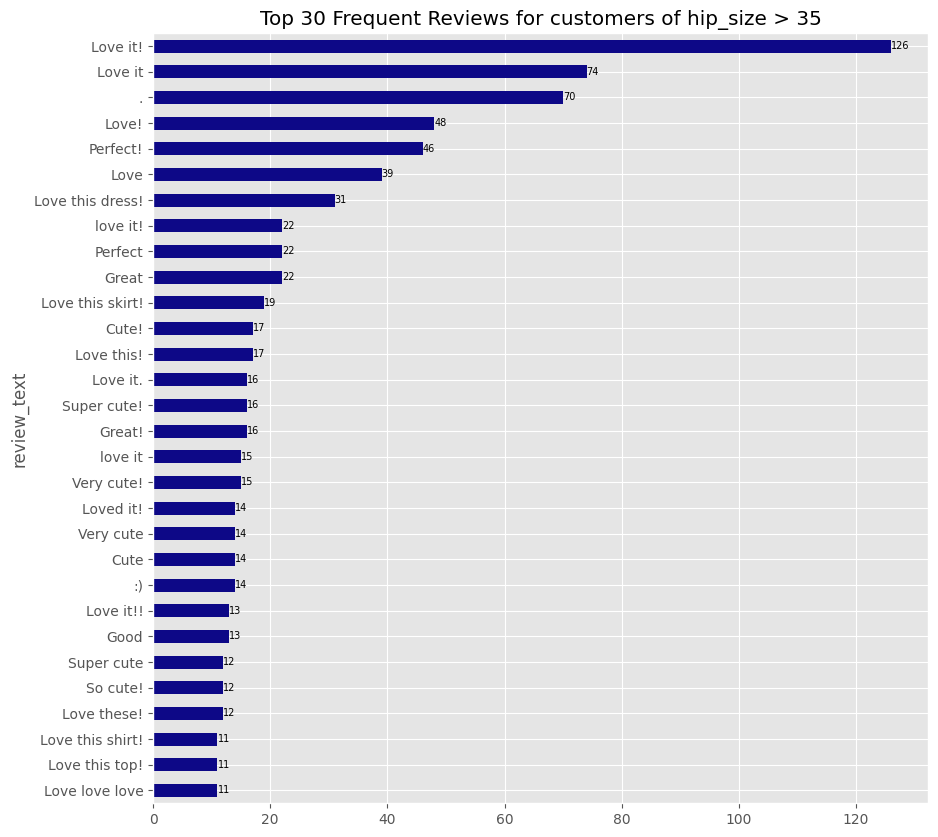

In [36]:
review_counts = df2['review_text'].value_counts().head(30).sort_values().plot(kind='barh', title='Top 30 Frequent Reviews for customers of hip_size > 35', 
                                                                              figsize=(10,10), colormap='plasma')
for i,v in enumerate(df2['review_text'].value_counts().head(30).sort_values(ascending=False)):
    plt.text(v, 29-i, str(v), va='center', fontsize=7)
plt.show()

#### Most common reviews also show positive sentiment for dresses.

---

### 11. What is the relationship between height and weight? Describe what kind of relationship it has

#### To be done

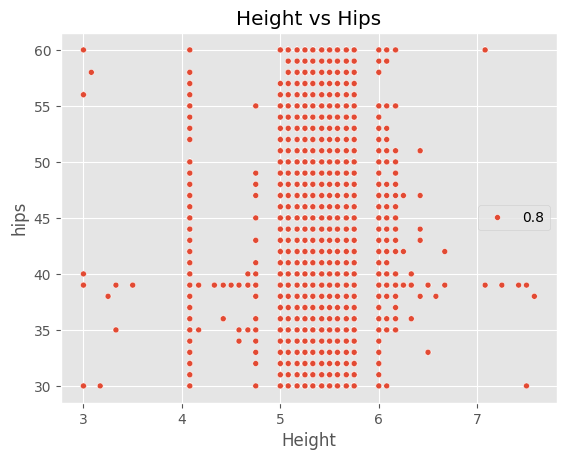

In [46]:
sns.scatterplot(data=df, x='Height', y='hips', size=0.8)
plt.title('Height vs Hips')
plt.show()

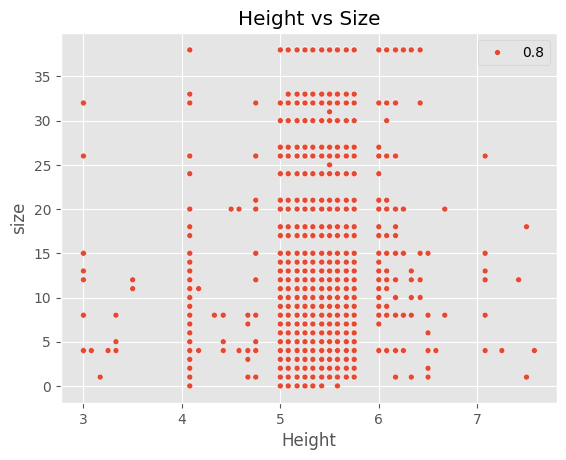

In [47]:
sns.scatterplot(data=df, x='Height', y='size', size=0.8)
plt.title('Height vs Size')
plt.show()

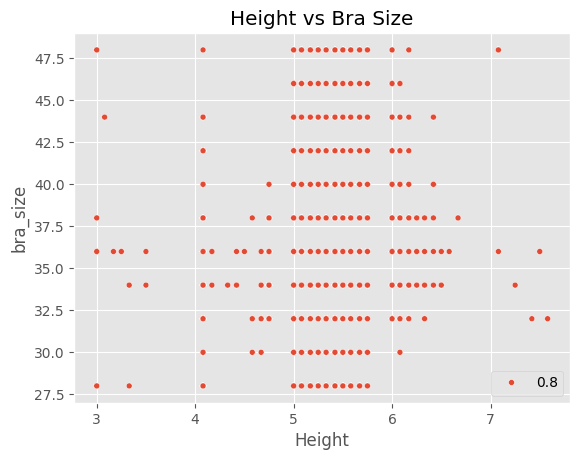

In [48]:
sns.scatterplot(data=df, x='Height', y='bra_size', size=0.8)
plt.title('Height vs Bra Size')
plt.show()

---

### 12. Plot the pair plot for the numerical plot. Explain according to your problem statement how the pair plot would help you.

In [41]:
df_num = df.drop('Sentiment', axis=1).select_dtypes(np.number)
df_num.columns

Index(['item_id', 'size', 'quality', 'hips', 'bra_size', 'Height', 'user_id',
       'shoe_size'],
      dtype='object')

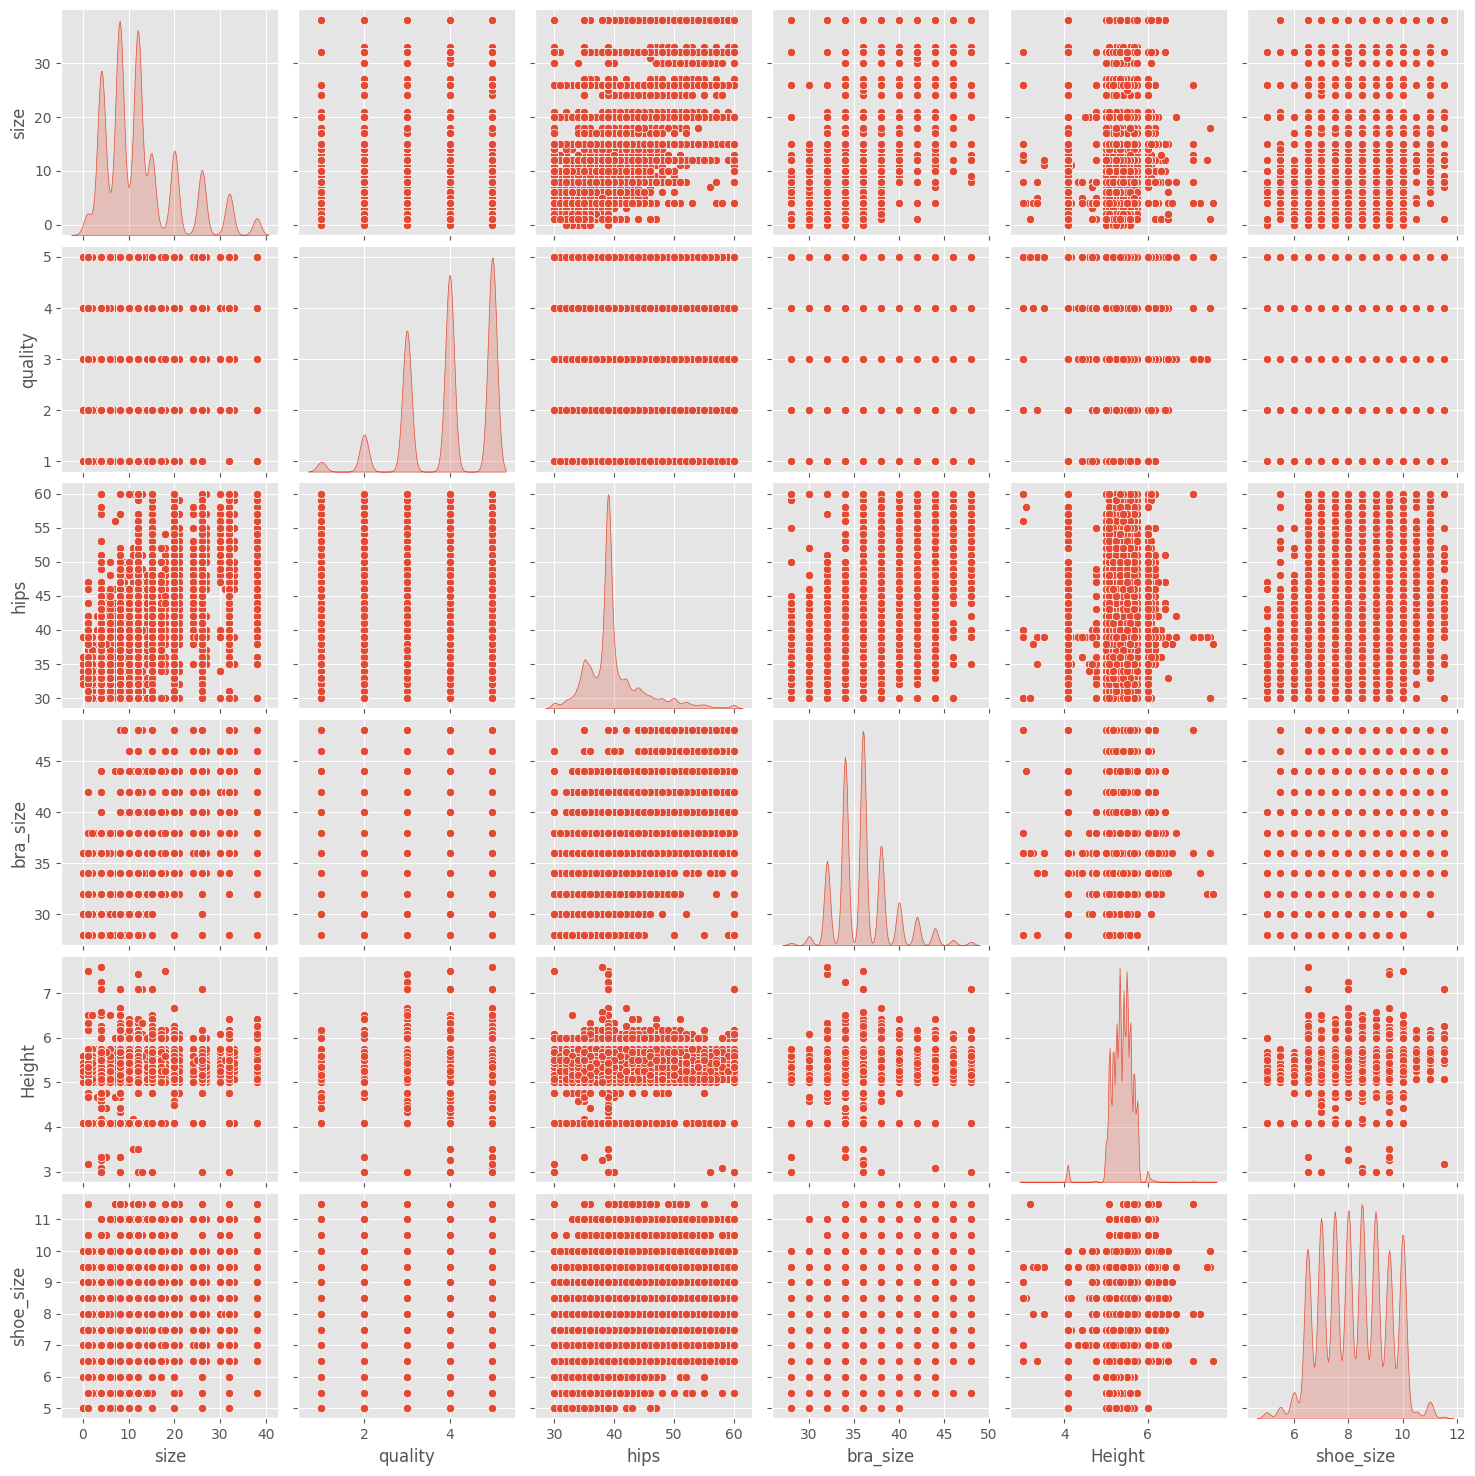

In [42]:
sns.pairplot(df_num.drop(columns=['item_id','user_id'], axis=1), diag_kind='kde', palette="viridis")
plt.show()

#### Not much to say from this..let's look at Heat Map to see correlations between variables.

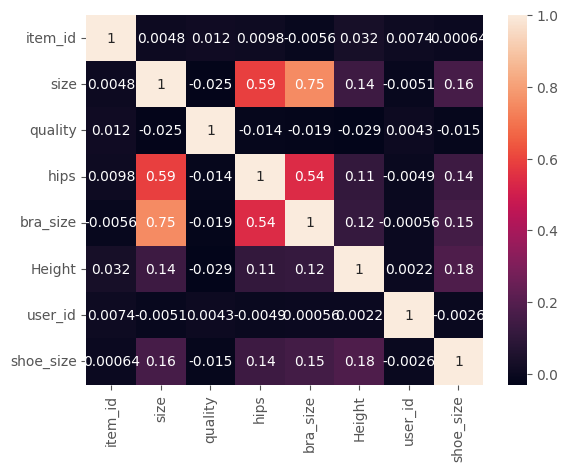

In [50]:
sns.heatmap(df_num.corr(), annot=True)
plt.show()